In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset



In [21]:
import random
import os

def set_seed(seed: int = 42):
    """
    Set seed for reproducibility across Python, NumPy, and PyTorch.
    Ensures deterministic behavior where possible.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # Deterministic settings for PyTorch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
SEED = 42
set_seed(SEED)

# Optional: confirm
print("Seed set to:", SEED)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))


Seed set to: 42
CUDA available: True
Device: 0 Tesla T4


In [22]:

train = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv')
train = pd.DataFrame(train)

In [23]:
train.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Category Misconception
0,0.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN,True_Correct- NA
1,1.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN,True_Correct- NA


In [24]:
train['Misconception'].unique()

array([nan, 'Incomplete', 'WNB', 'SwapDividend', 'Mult', 'FlipChange',
       'Irrelevant', 'Wrong_Fraction', 'Additive', 'Not_variable',
       'Adding_terms', 'Inverse_operation', 'Inversion', 'Duplication',
       'Wrong_Operation', 'Whole_numbers_larger', 'Longer_is_bigger',
       'Ignores_zeroes', 'Shorter_is_bigger', 'Wrong_fraction',
       'Adding_across', 'Denominator-only_change',
       'Incorrect_equivalent_fraction_addition', 'Division',
       'Subtraction', 'Unknowable', 'Definition', 'Interior', 'Positive',
       'Tacking', 'Wrong_term', 'Firstterm', 'Base_rate',
       'Multiplying_by_4', 'Certainty', 'Scale'], dtype=object)

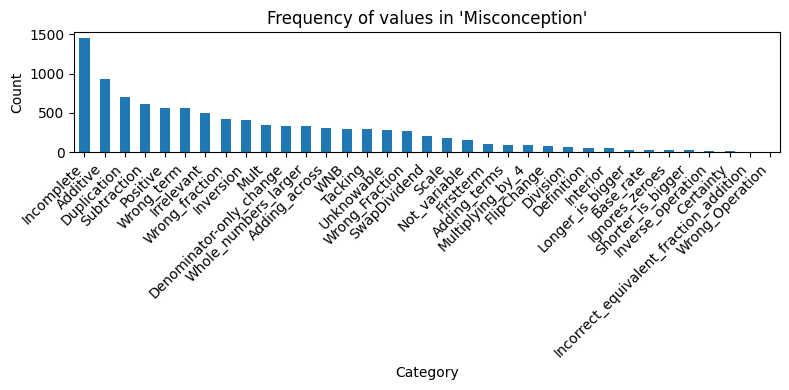

In [25]:
# containace of the misconception

import pandas as pd
import matplotlib.pyplot as plt

object_cols = ['Misconception']

for col in object_cols:
    plt.figure(figsize=(8,4))
    train[col].value_counts().plot(kind="bar")
    plt.title(f"Frequency of values in '{col}'")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


In [26]:
# we will firstly fine tune a bnary classification model on questionText and  MC_answer 
# to predict weathr it is tre or false
# then we will train another model on questiontext, MC-answer, and studentExplanation to predict
# 3 classes misconception, correct, neither (or 0,1,2 then we will map this)
# Again we train a model for multi classification of the Misconceptions, the model will be fine tuned on
# questionText, MC_answer, (weather correct, neither or miconception), (weather true or false), studentExplanation

# Finall we will join all the predictions according to the submition format e.g True_Neither- NA


In [27]:
train.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Category Misconception
0,0.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN,True_Correct- NA
1,1.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN,True_Correct- NA


In [28]:
test = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')
test.head(2)

,row_id,QuestionId,QuestionText,QuestionText.1,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,i think this answer is because 3 triangles are...


In [29]:
submission = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/submission.csv')
submission.head(2)

,row_id,Category Misconception
0,36696,True_Correct- NA True_Neither- NA False_Neithe...
1,36697,False_Misconception- Incomplete True_Correct- ...


In [ ]:
pip install transformers

In [ ]:
!pip install --upgrade transformers


In [ ]:
%pip install --upgrade transformers datasets

In [ ]:
'''
train = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv")
test = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/test.csv")
sample_sub = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/submission.csv")

print(train.head())
print(test.head())


# Step 1: Binary labels (True/False)
train["binary_label"] = train["Category"].apply(lambda x: 1 if "True" in str(x) else 0)

# Step 2: Ternary labels (Correct, Neither, Misconception)
# Step 2: Ternary labels (Correct, Neither, Misconception)
def ternary_mapper(x):
    x = str(x)  # make sure it's a string
    if "Correct" in x: 
        return 1
    elif "Neither" in x: 
        return 2
    elif "Misconception" in x: 
        return 0
    else: 
        return -1

train["ternary_label"] = train["Category"].apply(ternary_mapper)

# Step 3: Misconception labels
misconception_encoder = LabelEncoder()
train["misconception_label"] = misconception_encoder.fit_transform(
    train["Misconception"].fillna("NA")
)

num_misconceptions = len(misconception_encoder.classes_)
print("Number of misconception classes:", num_misconceptions)


from datasets import Dataset

def make_dataset(df, inputs, label_col):
    texts = df[inputs].astype(str).agg(" ".join, axis=1).tolist()
    labels = df[label_col].tolist()
    return Dataset.from_dict({"text": texts, "label": labels})

# Step 1 dataset
ds_binary = make_dataset(train, ["QuestionText", "MC_Answer"], "binary_label")

# Step 2 dataset
ds_ternary = make_dataset(train, ["QuestionText", "MC_Answer", "StudentExplanation"], "ternary_label")

# Step 3 dataset
ds_misconception = make_dataset(train, ["QuestionText", "MC_Answer", "StudentExplanation"], "misconception_label")



MODEL_NAME = "distilbert-base-uncased"  # small + fast
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

ds_binary = ds_binary.map(tokenize_function, batched=True)
ds_ternary = ds_ternary.map(tokenize_function, batched=True)
ds_misconception = ds_misconception.map(tokenize_function, batched=True)

ds_binary.set_format("torch")
ds_ternary.set_format("torch")
ds_misconception.set_format("torch")


def train_model(dataset, num_labels, output_dir):
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir=output_dir,
        do_eval=True,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_steps=100,
        disable_tqdm=False   # ✅ ensure progress bar is shown

    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=dataset,  # TODO: add real val split
        tokenizer=tokenizer
    )

    trainer.train()
    return trainer


binary_trainer = train_model(ds_binary, num_labels=2, output_dir="./binary_model")
ternary_trainer = train_model(ds_ternary, num_labels=3, output_dir="./ternary_model")
misconception_trainer = train_model(ds_misconception, num_labels=num_misconceptions, output_dir="./mis_model")

'''

In [ ]:


# Load CSV
train = pd.read_csv("/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv")

# Labels
train["binary_label"] = train["Category"].apply(lambda x: 1 if str(x).split("_")[0].lower() == "true" else 0)

# Dataset
texts = ("Question is " + train["QuestionText"].astype(str) + "Student answer is " + train["MC_Answer"].astype(str)).tolist()
labels = train["binary_label"].tolist()
dataset = Dataset.from_dict({"text": texts, "label": labels})

# Tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
dataset = dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length", max_length=128), batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Train/val split
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir="./binary_model",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    disable_tqdm=False,
    report_to="none"  # avoids trying to log to WandB/other
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
)

# Train
trainer.train()

# After trainer.train()
model.save_pretrained("./binary_model_final")
tokenizer.save_pretrained("./binary_model_final")

# Check CUDA
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))


In [30]:
# Paths
MODEL_NAME = "distilbert-base-uncased"
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/3/binary_model"  # same as output_dir used in training
TEST_CSV = "/kaggle/input/map-charting-student-math-misunderstandings/test.csv"

# Load test data
test_df = pd.read_csv(TEST_CSV)

# Prepare text
texts = ("Question is " + test_df["QuestionText"].astype(str) + " Student answer is " + test_df["StudentExplanation"].astype(str)).tolist()

# Load tokenizer and model
tokenizer_binary = AutoTokenizer.from_pretrained(MODEL_DIR)
model_binary = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model_binary.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_binary.to(device)
binary_model = model_binary

# Tokenize
encodings = tokenizer_binary(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)
import torch
from tqdm import tqdm

batch_size = 32  # reduce if still OOM
binary_preds = []

binary_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
binary_model.to(device)

# Move encodings to CPU temporarily if needed
input_ids_all = encodings["input_ids"]
attention_mask_all = encodings["attention_mask"]

for i in tqdm(range(0, len(input_ids_all), batch_size)):
    batch_input_ids = input_ids_all[i:i+batch_size].to(device)
    batch_attention_mask = attention_mask_all[i:i+batch_size].to(device)

    with torch.no_grad():
        outputs = binary_model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        binary_preds.extend(batch_preds)

# Add predictions to dataframe
test_df["binary_pred"] = binary_preds
print(test_df[["QuestionText", "StudentExplanation", "binary_pred"]].head())


100%|██████████| 1/1 [00:00<00:00, 58.67it/s]

                                        QuestionText  \
0  What fraction of the shape is not shaded? Give...   
1  What fraction of the shape is not shaded? Give...   
2                      Which number is the greatest?   

                                  StudentExplanation  binary_pred  
0  I think that 1/3 is the answer, as it's the si...            0  
1  i think this answer is because 3 triangles are...            0  
2     because the 2 makes it higher than the others.            0  


In [17]:
test_df['binary_pred'].nunique()

1

In [18]:
def ternary_mapper(x):
    # Take the last part after splitting by "_"
    last_part = str(x).split("_")[-1].lower()
    
    if last_part == "correct":
        return 1
    elif last_part == "neither":
        return 2
    elif last_part == "misconception":
        return 0
    else:
        return -1

# Apply to the column
train["ternary_label"] = train["Category"].apply(ternary_mapper)


In [19]:
train.head(3)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Category Misconception,ternary_label
0,0.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN,True_Correct- NA,1
1,1.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN,True_Correct- NA,1
2,2.0,31772.0,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN,True_Neither- NA,2


In [ ]:
train_valid = train[train["ternary_label"].isin([0,1,2])].copy()

def make_ternary_dataset(df):
    # Concatenate MC_Answer + StudentExplanation + binary prediction as string
    df["input_text"] = "Question is " + df["QuestionText"].astype(str) + "Student answer is "+df["MC_Answer"].astype(str)+ "Score is (1=True, 0=False)  " + df["binary_pred"].astype(str) + "Student explanation is " + df["StudentExplanation"].astype(str) 
    texts = df["input_text"].tolist()
    labels = df["ternary_label"].tolist()
    return Dataset.from_dict({"text": texts, "label": labels})

ds_ternary = make_ternary_dataset(train_valid)


In [ ]:
assert all(l in [0,1,2] for l in ds_ternary["label"]), "Invalid labels detected!"


we will need to train it on more epochs

In [ ]:
# Tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

ds_ternary = ds_ternary.map(tokenize_function, batched=True)
ds_ternary.set_format("torch")
ds_ternary = ds_ternary.train_test_split(test_size=0.2, seed=42)

# ----------------------------
# 6️⃣ Train ternary model
# ----------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
output_dir = "./ternary_model"

training_args = TrainingArguments(
    output_dir="./ternary_model",
    do_eval=True,
    per_device_train_batch_size=16,  # reduce if OOM occurs
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    disable_tqdm=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_ternary['train'],
    eval_dataset=ds_ternary['test'],  # ideally use a real validation split
    tokenizer=tokenizer
)

trainer.train()

    # Save model + tokenizer
model.save_pretrained("./ternary_model_final")
tokenizer.save_pretrained("./ternary_model_final")
    
# ----------------------------
# 9️⃣ Confirm CUDA
# ----------------------------
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))


In [31]:

# Paths
MODEL_NAME = "distilbert-base-uncased"
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/3/ternary_model"  # same as output_dir used in training
TEST_CSV = "/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv"

# Load test data
 # will be changed to test csv for submission

# Prepare text
texts = ("Student explanation is " + test_df["StudentExplanation"].astype(str) + " Score is (1=true, 0=false) " + test_df["binary_pred"].astype(str)).tolist()

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize
encodings = tokenizer(texts, truncation=True, padding="max_length", return_tensors="pt")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)
import torch
from tqdm import tqdm

batch_size = 32  # reduce if still OOM
ternary_preds = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move encodings to CPU temporarily if needed
input_ids_all = encodings["input_ids"]
attention_mask_all = encodings["attention_mask"]

for i in tqdm(range(0, len(input_ids_all), batch_size)):
    batch_input_ids = input_ids_all[i:i+batch_size].to(device)
    batch_attention_mask = attention_mask_all[i:i+batch_size].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        ternary_preds.extend(batch_preds)

# Add predictions to dataframe
test_df["ternary_pred"] = ternary_preds
print(test_df[["StudentExplanation", "binary_pred", "ternary_pred"]].head())


100%|██████████| 1/1 [00:00<00:00, 14.90it/s]

                                  StudentExplanation  binary_pred  \
0  I think that 1/3 is the answer, as it's the si...            0   
1  i think this answer is because 3 triangles are...            0   
2     because the 2 makes it higher than the others.            0   

   ternary_pred  
0             2  
1             2  
2             2  


In [32]:
test_df.head(30)

,row_id,QuestionId,QuestionText,QuestionText.1,StudentExplanation,binary_pred,ternary_pred
0,36696,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,"I think that 1/3 is the answer, as it's the si...",0,2
1,36697,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,i think this answer is because 3 triangles are...,0,2
2,36698,32835,Which number is the greatest?,Which number is the greatest?,because the 2 makes it higher than the others.,0,2


In [29]:
train['Misconception'] = train['Misconception'].replace('nan', np.nan)

# Get all unique values, including NaN
unique_values = train['Misconception'].unique()

# Create a mapping: NaN -> 0, others -> 1, 2, ...
label_map = {}
label_index = 1  # start from 1 because we want NaN to be 0
for val in unique_values:
    if pd.isna(val):
        label_map[val] = 0
    else:
        label_map[val] = label_index
        label_index += 1

# Apply mapping to create new label column
train['Misconception_label'] = train['Misconception'].map(label_map)

# Optional: check the mapping
print(label_map)
print(train[['Misconception', 'Misconception_label']].head())

{nan: 0, 'Incomplete': 1, 'WNB': 2, 'SwapDividend': 3, 'Mult': 4, 'FlipChange': 5, 'Irrelevant': 6, 'Wrong_Fraction': 7, 'Additive': 8, 'Not_variable': 9, 'Adding_terms': 10, 'Inverse_operation': 11, 'Inversion': 12, 'Duplication': 13, 'Wrong_Operation': 14, 'Whole_numbers_larger': 15, 'Longer_is_bigger': 16, 'Ignores_zeroes': 17, 'Shorter_is_bigger': 18, 'Wrong_fraction': 19, 'Adding_across': 20, 'Denominator-only_change': 21, 'Incorrect_equivalent_fraction_addition': 22, 'Division': 23, 'Subtraction': 24, 'Unknowable': 25, 'Definition': 26, 'Interior': 27, 'Positive': 28, 'Tacking': 29, 'Wrong_term': 30, 'Firstterm': 31, 'Base_rate': 32, 'Multiplying_by_4': 33, 'Certainty': 34, 'Scale': 35}
  Misconception  Misconception_label
0           NaN                    0
1           NaN                    0
2           NaN                    0
3           NaN                    0
4           NaN                    0


In [30]:
train.tail(4023)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,Category Misconception,binary_label,binary_pred,ternary_pred,Misconception_label
33060,33060.0,91695.0,Dots have been arranged in these patterns: [Im...,\( 22 \),the formula for this pattern is 4n+2 this is b...,False_Misconception,Wrong_term,False_Misconception- Wrong_term,0,0,0,30
33061,33061.0,91695.0,Dots have been arranged in these patterns: [Im...,\( 22 \),the lines of dots go up by 1 each time plus 2,False_Neither,NaN,False_Neither- NA,0,0,2,0
33062,33062.0,91695.0,Dots have been arranged in these patterns: [Im...,\( 22 \),the nth number is +4 so pattern 5 would be 18+...,False_Misconception,Wrong_term,False_Misconception- Wrong_term,0,0,2,30
33063,33063.0,91695.0,Dots have been arranged in these patterns: [Im...,\( 22 \),the nth term is 4n+2. pattern 5 is next. 4 x 5...,False_Misconception,Wrong_term,False_Misconception- Wrong_term,0,0,2,30
33064,33064.0,91695.0,Dots have been arranged in these patterns: [Im...,\( 22 \),the nth term is 4n-2 so when u substitute 6 in...,False_Misconception,Wrong_term,False_Misconception- Wrong_term,0,0,2,30
...,...,...,...,...,...,...,...,...,...,...,...,...
37078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,0,0,2,0
37079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,0,0,2,0
37080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,0,0,2,0
37081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,0,0,2,0


In [31]:
train.to_csv('new_train.csv', index=False)

In [32]:
train = pd.DataFrame(pd.read_csv('/kaggle/working/new_train.csv'))

In [34]:

def make_misconception_dataset(df):
    # Concatenate MC_Answer + StudentExplanation + binary prediction as string
    df["input_text"] = "Question is " + df["QuestionText"].astype(str) + "Student answer is "+df["MC_Answer"].astype(str)+ "Score is (1=True, 0=False)  " + df["binary_pred"].astype(str) + "Student explanation is " + df["StudentExplanation"].astype(str) + "CATEGORY IS <VERY IMPORTANT> " + df['ternary_pred'].astype(str) +" </VERY IMPORTANT>"
    texts = df["input_text"].tolist()
    labels = df["Misconception_label"].tolist()
    return Dataset.from_dict({"text": texts, "label": labels})

ds_misconception_ = make_misconception_dataset(train)


In [65]:
# Tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

ds_misconception_ = ds_misconception_.map(tokenize_function, batched=True)
ds_misconception_.set_format("torch")
ds_misconception = ds_misconception_.train_test_split(test_size=0.2, seed=42)

# ----------------------------
# 6️⃣ Train ternary model
# ----------------------------
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=36)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
output_dir = "./misconception_model"

training_args = TrainingArguments(
    output_dir="./misconception_model",
    do_eval=True,
    per_device_train_batch_size=16,  # reduce if OOM occurs
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="no",
    disable_tqdm=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_misconception['train'],
    eval_dataset=ds_misconception['test'],  # ideally use a real validation split
    tokenizer=tokenizer
)

trainer.train()

    # Save model + tokenizer
model.save_pretrained("./misconception_model_final")
tokenizer.save_pretrained("./misconception_model_final")
    
# ----------------------------
# 9️⃣ Confirm CUDA
# ----------------------------
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.current_device(), torch.cuda.get_device_name(0))


Map:   0%|          | 0/37083 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/3931683274.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,1.365500
200,0.758000
300,0.576400
400,0.494100
500,0.428400
600,0.428400
700,0.418700
800,0.371000
900,0.378200


CUDA available: True
Device: 0 Tesla T4


In [66]:
print(model.config.num_labels)


36


In [33]:

# Paths
MODEL_NAME = "distilbert-base-uncased"
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/3/misconception_model"  # same as output_dir used in training
TEST_CSV = "/kaggle/input/map-charting-student-math-misunderstandings/train_Clean.csv"

# Load test data
test_df  # will be changed to test csv for submission

# Prepare text
texts = ("Question is " + test_df["QuestionText"].astype(str) + "Score is (1=True, 0=False)  " + test_df["binary_pred"].astype(str) + "Student explanation is " + test_df["StudentExplanation"].astype(str) + "CATEGORY IS <VERY IMPORTANT> " + test_df['ternary_pred'].astype(str) +" </VERY IMPORTANT>").tolist()

# Load tokenizer and model

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize
encodings = tokenizer(texts, truncation=True, padding="max_length", return_tensors="pt")
input_ids = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)
import torch
from tqdm import tqdm

batch_size = 32  # reduce if still OOM
misconception_preds = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move encodings to CPU temporarily if needed
input_ids_all = encodings["input_ids"]
attention_mask_all = encodings["attention_mask"]

for i in tqdm(range(0, len(input_ids_all), batch_size)):
    batch_input_ids = input_ids_all[i:i+batch_size].to(device)
    batch_attention_mask = attention_mask_all[i:i+batch_size].to(device)

    with torch.no_grad():
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        misconception_preds.extend(batch_preds)

# Add predictions to dataframe
test_df["misconception_pred"] = misconception_preds


100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


In [34]:
test_df.head()

,row_id,QuestionId,QuestionText,QuestionText.1,StudentExplanation,binary_pred,ternary_pred,misconception_pred
0,36696,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,"I think that 1/3 is the answer, as it's the si...",0,2,2
1,36697,31772,What fraction of the shape is not shaded? Give...,What fraction of the shape is not shaded? Give...,i think this answer is because 3 triangles are...,0,2,0
2,36698,32835,Which number is the greatest?,Which number is the greatest?,because the 2 makes it higher than the others.,0,2,2


In [35]:
MODEL_DIR = "/kaggle/input/distilbert-uncased-fine-tuned/pytorch/default/3/misconception_model"  # same as output_dir used in training
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
print(model.config.num_labels)


3


In [43]:
import pandas as pd

# Load your CSV
df = test_df # replace with your path

# 1️⃣ Create decoding dictionaries
binary_map = {0: "False", 1: "True"}
ternary_map = {0: "Misconception", 1: "Correct", 2: "Neither"}
misconception_map = {0: "NA", 1: "scale", 2: "incomplete"}

# 2️⃣ Decode columns
df["binary_decoded"] = df["binary_pred"].map(binary_map)
df["ternary_decoded"] = df["ternary_pred"].map(ternary_map)
df["misconception_decoded"] = df["misconception_pred"].map(misconception_map)

# 3️⃣ Merge into a single feature
df["CategoryMisconception"] = (
    df["binary_decoded"] + "_" + df["ternary_decoded"] + "- " + df["misconception_decoded"]
)

# 4️⃣ Keep only relevant columns for clarity
merged_df = df[["row_id", "CategoryMisconception"]]

# Optional: If you want unique values per QuestionId
# merged_df = merged_df.groupby("QuestionId")["Misconception"].apply(list).reset_index()

print(merged_df.head())


   row_id      CategoryMisconception
0   36696  False_Neither- incomplete
1   36697          False_Neither- NA
2   36698  False_Neither- incomplete


In [44]:
merged_df.to_csv('submission.csv', index = False)

In [45]:
submission = pd.read_csv('/kaggle/working/submission.csv')
submission

,row_id,CategoryMisconception
0,36696,False_Neither- incomplete
1,36697,False_Neither- NA
2,36698,False_Neither- incomplete
